In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import class_weight
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

In [4]:
data = pd.read_csv(r"C:\Users\dell\Downloads\datasets\phishing\Phishing_Email.csv")

In [5]:
df = data
df

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email
...,...,...,...
18645,18646,date a lonely housewife always wanted to date ...,Phishing Email
18646,18647,request submitted : access request for anita ....,Safe Email
18647,18648,"re : important - prc mtg hi dorn & john , as y...",Safe Email
18648,18649,press clippings - letter on californian utilit...,Safe Email


In [17]:
df['Email Type'].value_counts()

Email Type
Safe Email        11322
Phishing Email     7328
Name: count, dtype: int64

In [18]:
df.isna().sum()

Unnamed: 0     0
Email Text    16
Email Type     0
dtype: int64

In [19]:
df = df.dropna()

In [20]:
df.isna().sum()

Unnamed: 0    0
Email Text    0
Email Type    0
dtype: int64

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18634 entries, 0 to 18649
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18634 non-null  int64 
 1   Email Text  18634 non-null  object
 2   Email Type  18634 non-null  object
dtypes: int64(1), object(2)
memory usage: 582.3+ KB


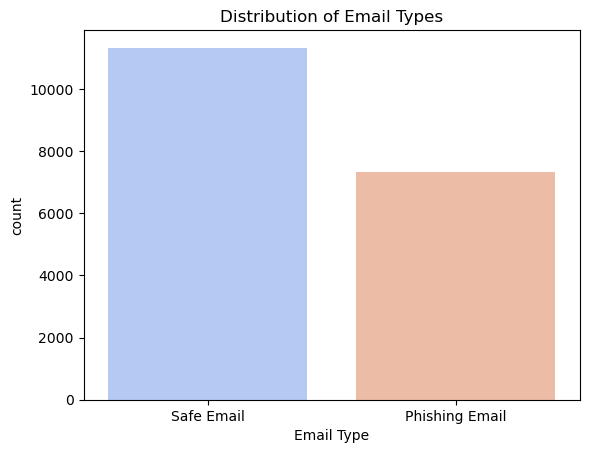

In [22]:
sns.countplot(x="Email Type", data = df, palette = 'coolwarm')
plt.title("Distribution of Email Types")
plt.show()

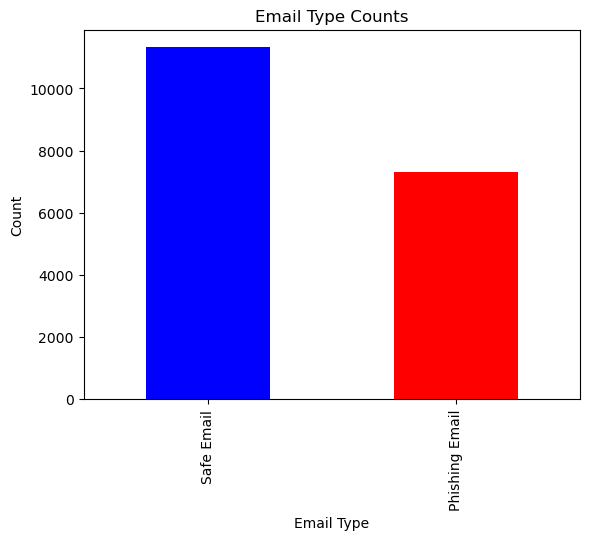

In [23]:
df["Email Type"].value_counts().plot(kind = "bar", color = ["blue","red"])
plt.title("Email Type Counts")
plt.xlabel("Email Type")
plt.ylabel("Count")
plt.show()

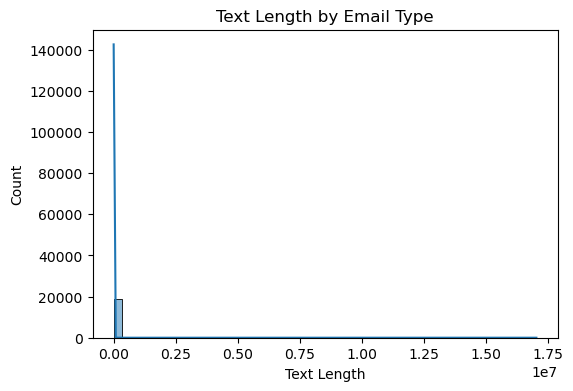

In [24]:
df["Text Length"] = df["Email Text"].astype(str).apply(len)
plt.figure(figsize = (6,4))
sns.histplot(df["Text Length"], bins = 50, kde = True)
plt.title("Text Length by Email Type")
plt.show()

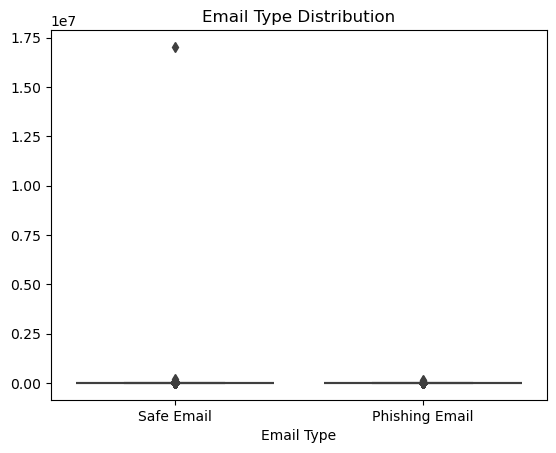

In [25]:
sns.boxplot(x="Email Type", y="Text Length", data = df)
plt.title("Email Type Distribution")
plt.ylabel("")
plt.show()

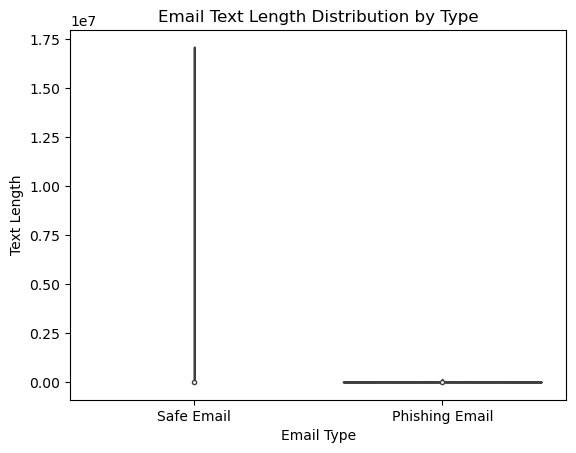

In [26]:
sns.violinplot(x = "Email Type", y = 'Text Length', data = df)
plt.title("Email Text Length Distribution by Type")
plt.show()

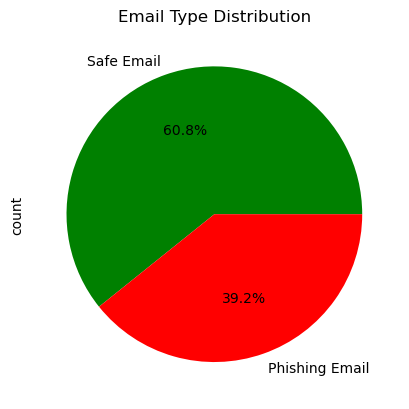

In [27]:
df["Email Type"].value_counts().plot.pie(autopct = "%1.1f%%", colors = ['green','red'])
plt.title("Email Type Distribution")
plt.show()

In [28]:
df.head()

,Unnamed: 0,Email Text,Email Type,Text Length
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,1030
1,1,the other side of * galicismos * * galicismo *...,Safe Email,479
2,2,re : equistar deal tickets are you still avail...,Safe Email,1245
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email,688
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email,441


In [29]:
df["Email Type"] = df["Email Type"].map({"Safe Email":0, "Phishing Email":1})
df

,Unnamed: 0,Email Text,Email Type,Text Length
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",0,1030
1,1,the other side of * galicismos * * galicismo *...,0,479
2,2,re : equistar deal tickets are you still avail...,0,1245
3,3,\nHello I am your hot lil horny toy.\n I am...,1,688
4,4,software at incredibly low prices ( 86 % lower...,1,441
...,...,...,...,...
18645,18646,date a lonely housewife always wanted to date ...,1,237
18646,18647,request submitted : access request for anita ....,0,477
18647,18648,"re : important - prc mtg hi dorn & john , as y...",0,1214
18648,18649,press clippings - letter on californian utilit...,0,213


In [30]:
X = df["Email Text"]
y = df["Email Type"]

In [31]:
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

In [32]:
# Helper to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

In [33]:
def advanced_clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # URLs
    text = re.sub(r'\S+@\S+', '', text)                  # Emails
    text = re.sub(r'[^a-z\s]', '', text)                 # Special chars & digits

    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if w not in stop_words]

    lemmatizer = WordNetLemmatizer()
    pos_tags = pos_tag(words)
    lemmatized_words = [lemmatizer.lemmatize(w, get_wordnet_pos(tag)) for w, tag in pos_tags]

    return " ".join(lemmatized_words)

In [34]:
# def advanced_clean_text(text):
#     text = text.lower()  
#     words = word_tokenize(text) 

#     stop_words = set(stopwords.words('english'))
#     words = [w for w in words if w not in stop_words]

#     stemmer = PorterStemmer()
#     stemmed_words = [stemmer.stem(w) for w in words]

#     return " ".join(stemmed_words) 

In [35]:
nltk.download('stopwords')
nltk.download('punkt')  # Also needed for tokenization
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [36]:
X = X.astype(str).apply(advanced_clean_text)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    shuffle = True, 
                                                    random_state = 42, 
                                                    stratify = y)

### TF-IDF unigrams

In [38]:
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X_train = tfidf.fit_transform(X_train)  
X_test = tfidf.transform(X_test) 

In [39]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train), 
                                                  y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

In [40]:
class_weights

array([0.82295462, 1.27410256])

In [41]:
class_weights_dict

{0: 0.8229546207353429, 1: 1.274102564102564}

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [43]:
model = LogisticRegression(class_weight=class_weights_dict) 
model.fit(X_train, y_train) 

LogisticRegression(class_weight={0: 0.8229546207353429, 1: 1.274102564102564})

In [44]:
y_pred = model.predict(X_test)

In [45]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))

Accuracy: 0.9624362758250604
Confusion Matrix:
 [[2156  109]
 [  31 1431]]
Precision: 0.9292207792207792
Recall: 0.978796169630643
F1-Score: 0.9533644237175216


In [46]:
def evaluate_model(y_test,y_pred):
    acc = accuracy_score(y_test, y_pred)
    p = precision_score(y_test, y_pred)
    r = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return acc, p, r, f1

In [47]:
from sklearn.utils.class_weight import compute_sample_weight

# Compute sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [48]:
models = {
    "LogisticRegression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "RandomForest": RandomForestClassifier(class_weight='balanced', n_estimators=100),
    "CatBoost": CatBoostClassifier(auto_class_weights='Balanced', verbose=0),
    "XGBoost": XGBClassifier(scale_pos_weight=1, use_label_encoder=False, eval_metric='logloss'),  # tune scale_pos_weight
    "AdaBoost": AdaBoostClassifier(n_estimators=100),
}

In [36]:
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictionss
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_acc , model_train_p, model_train_r, model_train_f1 = evaluate_model(y_train, y_train_pred)

    model_test_acc , model_test_p, model_test_r, model_test_f1 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Accuracy: {:.4f}".format(model_train_acc))
    print("- Precision: {:.4f}".format(model_train_p))
    print("- Recall: {:.4f}".format(model_train_r))
    print("- F1 score: {:.4f}".format(model_train_f1))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Accuracy: {:.4f}".format(model_test_acc))
    print("- Precision: {:.4f}".format(model_test_p))
    print("- Recall: {:.4f}".format(model_test_r))
    print("- F1 score:{:.4f}".format(model_test_f1))
    
    print('='*35)
    print('\n')

LogisticRegression
Model performance for Training set
- Accuracy: 0.9731
- Precision: 0.9455
- Recall: 0.9884
- F1 score: 0.9665
----------------------------------
Model performance for Test set
- Accuracy: 0.9624
- Precision: 0.9292
- Recall: 0.9788
- F1 score:0.9534


RandomForest
Model performance for Training set
- Accuracy: 0.9891
- Precision: 0.9732
- Recall: 0.9998
- F1 score: 0.9863
----------------------------------
Model performance for Test set
- Accuracy: 0.9584
- Precision: 0.9365
- Recall: 0.9590
- F1 score:0.9476


CatBoost
Model performance for Training set
- Accuracy: 0.9803
- Precision: 0.9529
- Recall: 0.9993
- F1 score: 0.9756
----------------------------------
Model performance for Test set
- Accuracy: 0.9563
- Precision: 0.9124
- Recall: 0.9829
- F1 score:0.9463


XGBoost
Model performance for Training set
- Accuracy: 0.9801
- Precision: 0.9567
- Recall: 0.9942
- F1 score: 0.9751
----------------------------------
Model performance for Test set
- Accuracy: 0.9563


In [37]:
cl = GradientBoostingClassifier()  # No direct class_weight; can use sample_weight  
cl.fit(X_train, y_train, sample_weight=sample_weights)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

model_train_acc , model_train_p, model_train_r, model_train_f1 = evaluate_model(y_train, y_train_pred)

model_test_acc , model_test_p, model_test_r, model_test_f1 = evaluate_model(y_test, y_test_pred)

print('Gradient Boosting')
    
print('Model performance for Training set')
print("- Accuracy: {:.4f}".format(model_train_acc))
print("- Precision: {:.4f}".format(model_train_p))
print("- Recall: {:.4f}".format(model_train_r))
print("- F1 score: {:.4f}".format(model_train_f1))

print('----------------------------------')

print('Model performance for Test set')
print("- Accuracy: {:.4f}".format(model_test_acc))
print("- Precision: {:.4f}".format(model_test_p))
print("- Recall: {:.4f}".format(model_test_r))
print("- F1 score:{:.4f}".format(model_test_f1))

print('='*35)
print('\n')

Gradient Boosting
Model performance for Training set
- Accuracy: 0.9411
- Precision: 0.8990
- Recall: 0.9574
- F1 score: 0.9273
----------------------------------
Model performance for Test set
- Accuracy: 0.9278
- Precision: 0.8891
- Recall: 0.9323
- F1 score:0.9102




In [38]:
from wordcloud import WordCloud

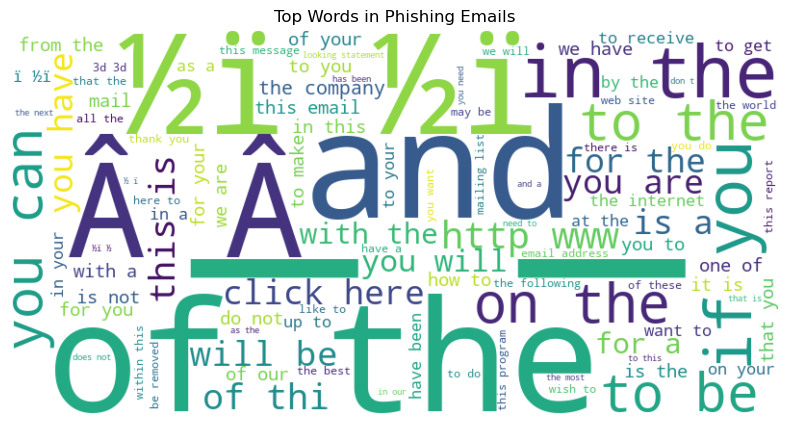

In [39]:
# Filter phishing emails only
phishing_text = " ".join(df[df['Email Type'] == 1]['Email Text'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      stopwords='english', max_words=100).generate(phishing_text)

# Plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Top Words in Phishing Emails")
plt.show()

In [49]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [50]:
df

,Unnamed: 0,Email Text,Email Type,Text Length
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",0,1030
1,1,the other side of * galicismos * * galicismo *...,0,479
2,2,re : equistar deal tickets are you still avail...,0,1245
3,3,\nHello I am your hot lil horny toy.\n I am...,1,688
4,4,software at incredibly low prices ( 86 % lower...,1,441
...,...,...,...,...
18645,18646,date a lonely housewife always wanted to date ...,1,237
18646,18647,request submitted : access request for anita ....,0,477
18647,18648,"re : important - prc mtg hi dorn & john , as y...",0,1214
18648,18649,press clippings - letter on californian utilit...,0,213


In [52]:
labels = df['Email Type']
labels

0        0
1        0
2        0
3        1
4        1
        ..
18645    1
18646    0
18647    0
18648    0
18649    1
Name: Email Type, Length: 18634, dtype: int64

In [53]:
df.isna().sum()

Unnamed: 0     0
Email Text     0
Email Type     0
Text Length    0
dtype: int64

In [54]:
df=df.dropna()

In [55]:
df.isna().sum()

Unnamed: 0     0
Email Text     0
Email Type     0
Text Length    0
dtype: int64

In [56]:
labels.isnull().sum()

0

In [62]:
labels

0        0
1        0
2        0
3        1
4        1
        ..
18645    1
18646    0
18647    0
18648    0
18649    1
Name: Email Type, Length: 18634, dtype: int64

In [58]:
texts = df['Email Text'].astype(str)

In [59]:
texts

0        re : 6 . 1100 , disc : uniformitarianism , re ...
1        the other side of * galicismos * * galicismo *...
2        re : equistar deal tickets are you still avail...
3        \nHello I am your hot lil horny toy.\n    I am...
4        software at incredibly low prices ( 86 % lower...
                               ...                        
18645    date a lonely housewife always wanted to date ...
18646    request submitted : access request for anita ....
18647    re : important - prc mtg hi dorn & john , as y...
18648    press clippings - letter on californian utilit...
18649                                                empty
Name: Email Text, Length: 18634, dtype: object

In [60]:
# Tokenize text
max_words = 10000
max_len = 200
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=max_len, padding='post')

In [61]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, stratify=labels)

## LSTM

In [47]:
# Build model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train
model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.1)

# Evaluate
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 27s 116ms/step - accuracy: 0.6161 - loss: 0.6379 - val_accuracy: 0.6841 - val_loss: 0.5115
Epoch 2/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 25s 117ms/step - accuracy: 0.7064 - loss: 0.4845 - val_accuracy: 0.6922 - val_loss: 0.4870
Epoch 3/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 25s 119ms/step - accuracy: 0.7205 - loss: 0.5318 - val_accuracy: 0.9383 - val_loss: 0.2500
Epoch 4/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 25s 117ms/step - accuracy: 0.9409 - loss: 0.2219 - val_accuracy: 0.9437 - val_loss: 0.1960
Epoch 5/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 25s 117ms/step - accuracy: 0.8670 - loss: 0.3684 - val_accuracy: 0.8384 - val_loss: 0.4014
Epoch 6/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 25s 117ms/step - accuracy: 0.8217 - loss: 0.4332 - val_accuracy: 0.8162 - val_loss: 0.4702
Epoch 7/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 25s 119ms/step - accuracy: 0.8412 - loss: 0.4359 - val_accuracy: 0.7659 - val_loss: 0.6045
Epoch 8/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 24s 117ms/step - accuracy: 0.7765 - loss: 0

In [64]:
# Build model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train
model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.1)

# Evaluate
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 34s 141ms/step - accuracy: 0.6324 - loss: 0.6278 - val_accuracy: 0.8203 - val_loss: 0.4509
Epoch 2/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 28s 133ms/step - accuracy: 0.7434 - loss: 0.5130 - val_accuracy: 0.8075 - val_loss: 0.5855
Epoch 3/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 37s 175ms/step - accuracy: 0.8631 - loss: 0.3716 - val_accuracy: 0.9249 - val_loss: 0.2499
Epoch 4/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 25s 117ms/step - accuracy: 0.9254 - loss: 0.2472 - val_accuracy: 0.9383 - val_loss: 0.2155
Epoch 5/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 20s 97ms/step - accuracy: 0.9437 - loss: 0.2032 - val_accuracy: 0.9215 - val_loss: 0.2313
Epoch 6/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 37s 175ms/step - accuracy: 0.9373 - loss: 0.1910 - val_accuracy: 0.9470 - val_loss: 0.1872
Epoch 7/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 39s 187ms/step - accuracy: 0.9629 - loss: 0.1451 - val_accuracy: 0.9457 - val_loss: 0.1940
Epoch 8/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 40s 190ms/step - accuracy: 0.9331 - loss: 0.

In [65]:
# Preprocess text
max_words = 10000
max_len = 200

In [68]:
# Build LSTM
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(64),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train and store history
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.1
)

Epoch 1/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 26s 107ms/step - accuracy: 0.6170 - loss: 0.6439 - val_accuracy: 0.6533 - val_loss: 0.6436
Epoch 2/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 22s 105ms/step - accuracy: 0.6424 - loss: 0.6146 - val_accuracy: 0.6023 - val_loss: 0.7065
Epoch 3/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 20s 97ms/step - accuracy: 0.6779 - loss: 0.5626 - val_accuracy: 0.6781 - val_loss: 0.5429
Epoch 4/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 21s 99ms/step - accuracy: 0.7732 - loss: 0.4731 - val_accuracy: 0.9054 - val_loss: 0.2677
Epoch 5/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 20s 94ms/step - accuracy: 0.9086 - loss: 0.2682 - val_accuracy: 0.9323 - val_loss: 0.2151
Epoch 6/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 0.9538 - loss: 0.1527 - val_accuracy: 0.9457 - val_loss: 0.1728
Epoch 7/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.9668 - loss: 0.1001 - val_accuracy: 0.9430 - val_loss: 0.1535
Epoch 8/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 21s 99ms/step - accuracy: 0.9418 - loss: 0.1587 

In [71]:
# Predict on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9616 - loss: 0.1621
Test Accuracy: 0.9589481949806213


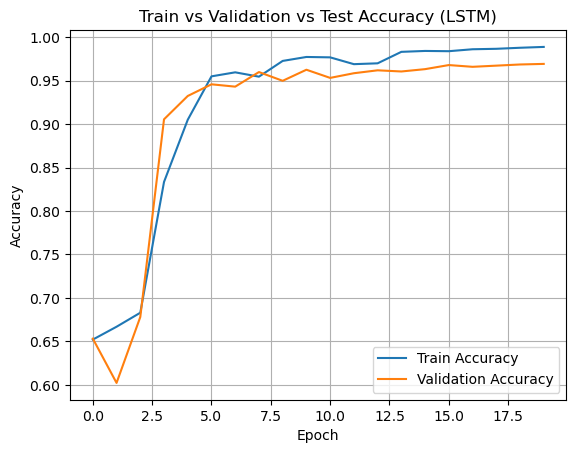

In [73]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.axhline(y=test_acc, color='red', linestyle='--', label='Test Accuracy')
plt.title('Train vs Validation vs Test Accuracy (LSTM)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [77]:
y_pred = model.predict(X_test)
# Convert probabilities to class labels
y_pred = (y_pred > 0.5).astype(int).ravel()

In [79]:
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,accuracy_score,precision_score,recall_score,f1_score

In [82]:
# Print evaluation metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Safe", "Phishing"]))

print("ROC AUC Score:", roc_auc_score(y_test, y_pred))
# print("Accuracy:", accuracy_score(y_test, y_pred))
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.4f}\nPrecision: {:.4f} \nRecall: {:.4f}\nF1_score: {:.4f}".format(accuracy,precision,recall,f1))

Confusion Matrix:
[[2151  114]
 [  39 1423]]

Classification Report:
              precision    recall  f1-score   support

        Safe       0.98      0.95      0.97      2265
    Phishing       0.93      0.97      0.95      1462

    accuracy                           0.96      3727
   macro avg       0.95      0.96      0.96      3727
weighted avg       0.96      0.96      0.96      3727

ROC AUC Score: 0.9614965437892391
Accuracy: 0.9589
Precision: 0.9258 
Recall: 0.9733
F1_score: 0.9490
